In [1]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Specify your working directory
wd = '/Users/j.schmitcelonis.com/Documents/Celo AI/uWaveGestureLibrary'
os.chdir(wd)

## Load data

In [2]:
def get_data(directory):
    """
    Extracts the raw .txt data and the classes. 
    Before executing this, please unzip all the rar files in the working directory.
    
    Args:
    directory: directory in which the unzipped data lies
    
    Returns:
    raw_data: list of np.arrays containing the .txt data
    labels: np.array of labels of each hand gestures
    n: dataset size
    """
    
    raw_data = []
    labels = []
    subdirs = [x[0] for x in os.walk(directory)]                                                                            
    for subdir in subdirs:
        files = os.walk(subdir).__next__()[2]
        
        for file in files:
            if file.endswith('.txt') and len(file)<7: # remove unnecessary files 
                os.remove(os.path.join(directory, subdir, file))
                
            elif file.endswith('.txt') and file != 'Readme.txt':
                x = []
                y = []
                z = []
                f = open(os.path.join(subdir, file))
                for line in f:
                    s = line.split()
                    x.append(float(s[0]))
                    y.append(float(s[1]))
                    z.append(float(s[2]))
                raw_data.append(np.concatenate(([x], [y], [z]), axis=0))
                labels.append(str.split(str.split(file, '-')[0], 'Acceleration')[1])
    
    # dataset size
    n = len(raw_data)
                
    return raw_data, np.subtract(np.array(labels, dtype=np.int32), 1), n

## Build dataset for various length time series data

Because the datapoints have varying numbers of measurements, we cannot just use the raw data for training. Instead we will build a sparse matrix where we will 'embed' the raw data into a 0-matrix to fit every datapoint into the same matrix.

In [3]:
def dataset(raw_data, n, normalize=False):
    """
    Builds our feature matrix from the raw data extracted using get_data() by flattening the x, y, z arrays
    into one array per datapoint.
    
    Args:
    raw_data: raw_data from get_data()
    n: dataset size from get_data()
    normalize: boolean to normalize our feature matrix or not. Since different people performed the hand gestures,
                normalization might be justified due to different accelerations.
    
    Returns:
    X: our feature matrix
    """
    n_features = 0
    # we will search for the maximum number of columns/features that our feature matrix must be able to hold
    for i in range(n):
        if raw_data[i].shape[1] > n_features:
            n_features = int(raw_data[i].shape[1])

    X = np.zeros((n, 3*n_features)) # 3*n_features bc. of three dimensions (x, y, z)
    
    # Embed the raw data into our sparse feature matrix X
    for i in range(n):
        X[i, :int(raw_data[i][0].shape[0])] = raw_data[i][0] # x
        X[i, n_features:n_features + int(raw_data[i][0].shape[0])] = raw_data[i][1] #y
        X[i, 2*n_features:2*n_features + int(raw_data[i][0].shape[0])] = raw_data[i][2] #z
    
    if normalize:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    return X

## Split data into train and test set

In [4]:
def split(X, y, train_size, validation=False, val_size=0):
    """
    Splits the dataset into train, test, and optionally validation sets
    
    Args:
    X: Feature matrix
    y: label array
    train_size: number between 0 and 1 representing the proportion of our training dataset
    
    Returns:
    X_train: Training feature matrix
    y_train: Training labels
    X_test: Testing feature matrix
    y_test: Testing labels
    """
    
    np.random.seed(1)
    n = X.shape[0]
    
    indices = np.random.permutation(n) # random permutation of indices
    
    if validation:
        train_n = np.round(n*train_size)
        val_n = np.round(n*val_size)
        
        train_indices = indices[:int(train_n)]
        val_indices = indices[int(train_n):int(train_n) + int(val_n)]
        test_indices = indices[int(train_n) + int(val_n):]
        
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        return X_train, y_train, X_val, y_val, X_test, y_test
        
    else:
        train_n = np.round(n*train_size)

        train_indices = indices[:int(train_n)]
        test_indices = indices[int(train_n):]

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        return X_train, y_train, X_test, y_test

## Logistic regression Model

In [5]:
class LogisticRegression:
    def __init__(self, learning_rate=0.15, n_iterations=50000, regularization=False, reg_strength=0, lr_decay=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_strength = reg_strength
        self.lr_decay = lr_decay
        
    def fit(self, X_train, y_train, validation=False, X_val=0, y_val=0):
        n_train_samples, n_features = X_train.shape
        n_classes = len(np.unique(y_train))
        
        np.random.seed(4)
        self.weights = np.random.normal(loc=0, scale=1.0, size=(n_features, n_classes))
        self.bias = np.random.normal(loc=0, scale=1.0, size=(1, n_classes))
        
        if validation:
            n_val_samples = X_val.shape[0]
            
            if self.regularization: # we perform L2 regularization here to prevent overfitting and too large weights
                ce_train_loss_reg = []
                ce_val_loss_reg = []
                
                for i in range(self.n_iterations):
                    # Forward pass
                    z = np.dot(X_train, self.weights) + self.bias
                    a = self.softmax(z)

                    # Backward pass to get gradients
                    dz = a - self.one_hot(y_train, n_classes)
                    dw = np.dot(X_train.T, dz) / n_train_samples + (self.reg_strength * self.weights) / n_train_samples
                    db = np.sum(dz, axis=0, keepdims=True) / n_train_samples + (self.reg_strength * self.bias) / n_train_samples

                    # Update parameters using gradient descent
                    if self.lr_decay is not None and i%100 == 0:
                        self.learning_rate -= self.lr_decay
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db

                    # Update categorical cross entropy loss
                    train_loss = (np.sum(-np.log(self.softmax(np.dot(X_train, self.weights) + self.bias)[np.arange(n_train_samples), y_train])) + 
                                       (self.reg_strength/2) * (np.sum(np.square(self.weights)) + np.sum(np.square(self.bias)))) / n_train_samples
                    
                    val_loss = (np.sum(-np.log(self.softmax(np.dot(X_val, self.weights) + self.bias)[np.arange(n_val_samples), y_val])) + 
                                       (self.reg_strength/2) * (np.sum(np.square(self.weights)) + np.sum(np.square(self.bias)))) / n_val_samples
                    
                    if i%100 == 0:
                        print("Iteration: ", i)
                        print("Train loss: ", train_loss)
                        print("Validation loss: ", val_loss)
                        
                    ce_train_loss_reg.append(train_loss)
                    ce_val_loss_reg.append(val_loss)
                    
                    if i > 10 and ce_val_loss_reg[i] > ce_val_loss_reg[i-10]:
                        break
                
                return np.array(ce_train_loss_reg, dtype=np.float128), np.array(ce_val_loss_reg, dtype=np.float128)
                
            else:
                ce_train_loss = []
                ce_val_loss = []

                for i in range(self.n_iterations):
                    # Forward pass
                    z = np.dot(X_train, self.weights) + self.bias
                    a = self.softmax(z)

                    # Backward pass to get gradients
                    dz = a - self.one_hot(y_train, n_classes)
                    dw = np.dot(X_train.T, dz) / n_train_samples
                    db = np.sum(dz, axis=0, keepdims=True) / n_train_samples

                    # Update parameters using gradient descent
                    if self.lr_decay is not None and i%100 == 0:
                        self.learning_rate -= self.lr_decay
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db

                    # Update categorical cross entropy loss
                    train_loss = (np.sum(-np.log(self.softmax(np.dot(X_train, self.weights) + self.bias)[np.arange(n_train_samples), y_train]))) / n_train_samples
                    
                    val_loss = (np.sum(-np.log(self.softmax(np.dot(X_val, self.weights) + self.bias)[np.arange(n_val_samples), y_val]))) / n_val_samples
                    
                    if i%100 == 0:
                        print("Iteration: ", i)
                        print("Train loss: ", train_loss)
                        print("Validation loss: ", val_loss)
                    
                    ce_train_loss.append(train_loss)
                    ce_val_loss.append(val_loss)
                    
                    if i > 10 and ce_val_loss[i] > ce_val_loss[i-10]:
                        break

                return np.array(ce_train_loss, dtype=np.float128), np.array(ce_val_loss, dtype=np.float128)
            
        else:
            if self.regularization: # we perform L2 regularization here to prevent overfitting and too large weights
                ce_loss_reg = []
                
                for i in range(self.n_iterations):
                    # Forward pass
                    z = np.dot(X_train, self.weights) + self.bias
                    a = self.softmax(z)

                    # Backward pass to get gradients
                    dz = a - self.one_hot(y_train, n_classes)
                    dw = np.dot(X_train.T, dz) / n_samples + (self.reg_strength * self.weights) / n_train_samples
                    db = np.sum(dz, axis=0, keepdims=True) / n_samples + (self.reg_strength * self.bias) / n_train_samples

                    # Update parameters using gradient descent
                    if self.lr_decay is not None and i%100 == 0:
                        self.learning_rate -= self.lr_decay
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db

                    # Update categorical cross entropy loss
                    train_loss = (np.sum(-np.log(self.softmax(np.dot(X_train, self.weights) + self.bias)[np.arange(n_train_samples), y_train])) + 
                                       (self.reg_strength/2) * (np.sum(np.square(self.weights)) + np.sum(np.square(self.bias)))) / n_train_samples
                    if i%100 == 0:
                        print("Iteration: ", i)
                        print("Train loss: ", train_loss)
                        
                    ce_loss_reg.append(train_loss)
                
                return np.array(ce_loss_reg, dtype=np.float128)
                
            else:
                ce_loss = []

                for i in range(self.n_iterations):
                    # Forward pass
                    z = np.dot(X_train, self.weights) + self.bias
                    a = self.softmax(z)

                    # Backward pass to get gradients
                    dz = a - self.one_hot(y_train, n_classes)
                    dw = np.dot(X_train.T, dz) / n_train_samples
                    db = np.sum(dz, axis=0, keepdims=True) / n_train_samples

                    # Update parameters using gradient descent
                    if self.lr_decay is not None and i%100 == 0:
                        self.learning_rate -= self.lr_decay
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db

                    # Update categorical cross entropy loss
                    train_loss = np.sum(-np.log(self.softmax(np.dot(X_train, self.weights) + self.bias)[np.arange(n_samples), y_train])) / n_samples
                    
                    if i%100 == 0:
                        print("Iteration: ", i)
                        print("Train loss: ", train_loss)
                        
                    ce_loss.append(train_loss)

                return np.array(ce_loss, dtype=np.float128)
            
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias # logits
        a = self.softmax(z)
        return z, np.argmax(a, axis=1)
    
    def softmax(self, z):
        z_max = np.max(z, axis=-1, keepdims=True)
        z = z - z_max
        eps = 1e-15 # prevent division by 0
        exp_z = np.exp(z)
        return exp_z / (np.sum(exp_z, axis=1, keepdims=True) + eps)
    
    def one_hot(self, y, n_classes):
        one_hot_y = np.zeros((len(y), n_classes))
        one_hot_y[np.arange(len(y)), y] = 1
        return one_hot_y
    
    def accuracy(self, y_pred, y_true):
        return (np.sum(y_pred == y_true)/len(y_true))

    def class_accuracy(self, y_pred, y_true, class_index):
        class_mask = (y_test == class_index)
        class_correct = np.sum(y_pred[class_mask] == y_test[class_mask])
        class_total = np.sum(class_mask)
        class_accuracy = class_correct / class_total
        return class_accuracy
    
    def confusion_matrix(self, y_pred, y_true, n_classes):
        confusion_matrix = np.zeros((n_classes, n_classes))
        for i in range(len(y_true)):
            confusion_matrix[y_true[i], y_pred[i]] += 1
        return sns.heatmap(confusion_matrix, annot=True, cmap="Blues")

## Data exploration

In [6]:
# Raw data extraction
raw_data, labels, n = get_data(wd)

### Is the dataset balanced?

In [7]:
print("Class counts: ", np.bincount(labels)) # get the count of each class
print("If datasets are imbalanced one has to account for that in logistic regressions, since the model tends to be biased to the majority class.")

Class counts:  [560 560 561 560 560 560 560 560]
If datasets are imbalanced one has to account for that in logistic regressions, since the model tends to be biased to the majority class.


### Are there significant outliers?

It makes sense to leave out datapoints with less than 10 acceleration recordings, because they cannot represent a whole gesture


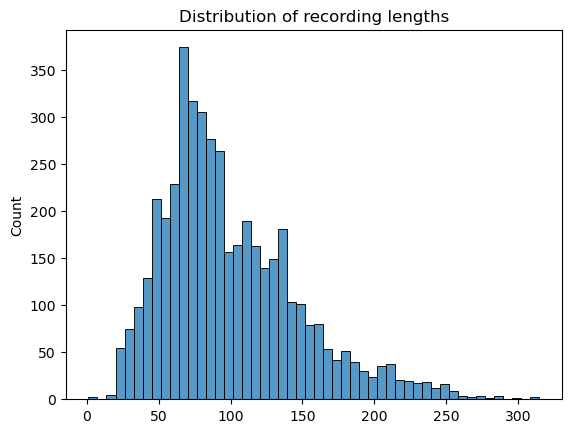

In [8]:
lens = np.array([raw_data[i].shape[1] for i in range(n)], dtype=np.int16)
sns.histplot(data=lens, bins=50).set(title="Distribution of recording lengths")
print("It makes sense to leave out datapoints with less than 10 acceleration recordings, because they cannot represent a whole gesture")

### Clean raw data

In [9]:
faulty_indices = []
for i in range(n):
    if len(raw_data[i].shape) < 2:
        faulty_indices.append(i)
    elif raw_data[i].shape[1] < 10:
        faulty_indices.append(i)
    else: continue
        

for i in faulty_indices:
    raw_data.pop(i)
labels = np.delete(labels, faulty_indices)    
n = len(raw_data)
print("We have {} datapoints in our cleaned dataset.".format(n))

We have 4479 datapoints in our cleaned dataset.


### Build clean dataset and split into train, validation, and test subsets

In [10]:
X = dataset(raw_data, n, normalize=True)
X_train, y_train, X_val, y_val, X_test, y_test = split(X, labels, train_size=0.75, validation=True, val_size=0.15)

## Training

In [11]:
# Training with regularization
model_reg = LogisticRegression(learning_rate=0.2, n_iterations=3500, regularization=True, reg_strength=22, lr_decay=2e-6)
train_loss_reg, val_loss_reg = model_reg.fit(X_train, y_train, validation=True, X_val=X_val, y_val=y_val)

Iteration:  0
Train loss:  49.16169249555866
Validation loss:  147.51388615359593
Iteration:  100
Train loss:  19.818038347099627
Validation loss:  93.08014221695697
Iteration:  200
Train loss:  14.784668609426172
Validation loss:  70.77244819034506
Iteration:  300
Train loss:  11.24427402759254
Validation loss:  54.1389446978459
Iteration:  400
Train loss:  8.617915216971994
Validation loss:  41.51409680130785
Iteration:  500
Train loss:  6.641164466089049
Validation loss:  31.88671397132598
Iteration:  600
Train loss:  5.1442460029555335
Validation loss:  24.542179671097685
Iteration:  700
Train loss:  4.007051836648475
Validation loss:  18.933902621065936
Iteration:  800
Train loss:  3.142414742508653
Validation loss:  14.650338124760989
Iteration:  900
Train loss:  2.484314232307017
Validation loss:  11.377161786955105
Iteration:  1000
Train loss:  1.9828368593314583
Validation loss:  8.887908656770398
Iteration:  1100
Train loss:  1.6003667355429763
Validation loss:  6.98925270271

## Inference

In [12]:
logits_train_reg, y_train_pred_reg = model_reg.predict(X_train)
logits_test_reg, y_pred_reg = model_reg.predict(X_test)
print("\nTrain Accuracy: {}%".format(100*np.round(model_reg.accuracy(y_train_pred_reg, y_train), decimals=3)))
print("\nTest Accuracy: {}%".format(100*np.round(model_reg.accuracy(y_pred_reg, y_test), decimals=3)))


Train Accuracy: 93.0%

Test Accuracy: 90.2%


## Training diagnostics & Visualizations

### Training and Validation loss

(0.0, 4.0)

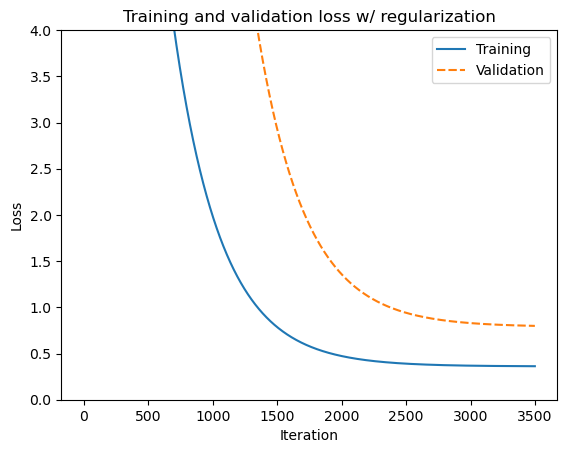

In [13]:
fig, ax = plt.subplots()
sns.lineplot(data=pd.DataFrame({'Training': train_loss_reg, 'Validation': val_loss_reg})).set(title="Training and validation loss w/ regularization")
plt.xlabel('Iteration')
plt.ylabel('Loss')
ax.set_ylim(0, 4)

### Are there performance differences for each class?

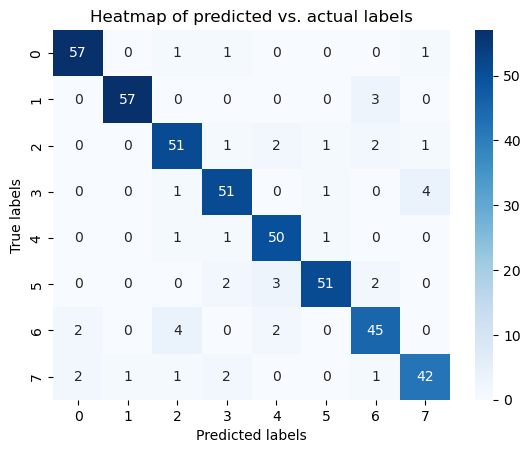

In [14]:
model_reg.confusion_matrix(y_pred_reg, y_test, len(np.unique(y_train))).set(title="Heatmap of predicted vs. actual labels")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Generally no clear misclassification pattern is observable and given an accuracy of over **90%**, the model performs reasonably well and captures the important underlying statistical dependencies.
However, different types of networks such as neural networks or transformers with an activation layer at the end, could most likely improve the performance even further, since they are able to learn more complex functions.

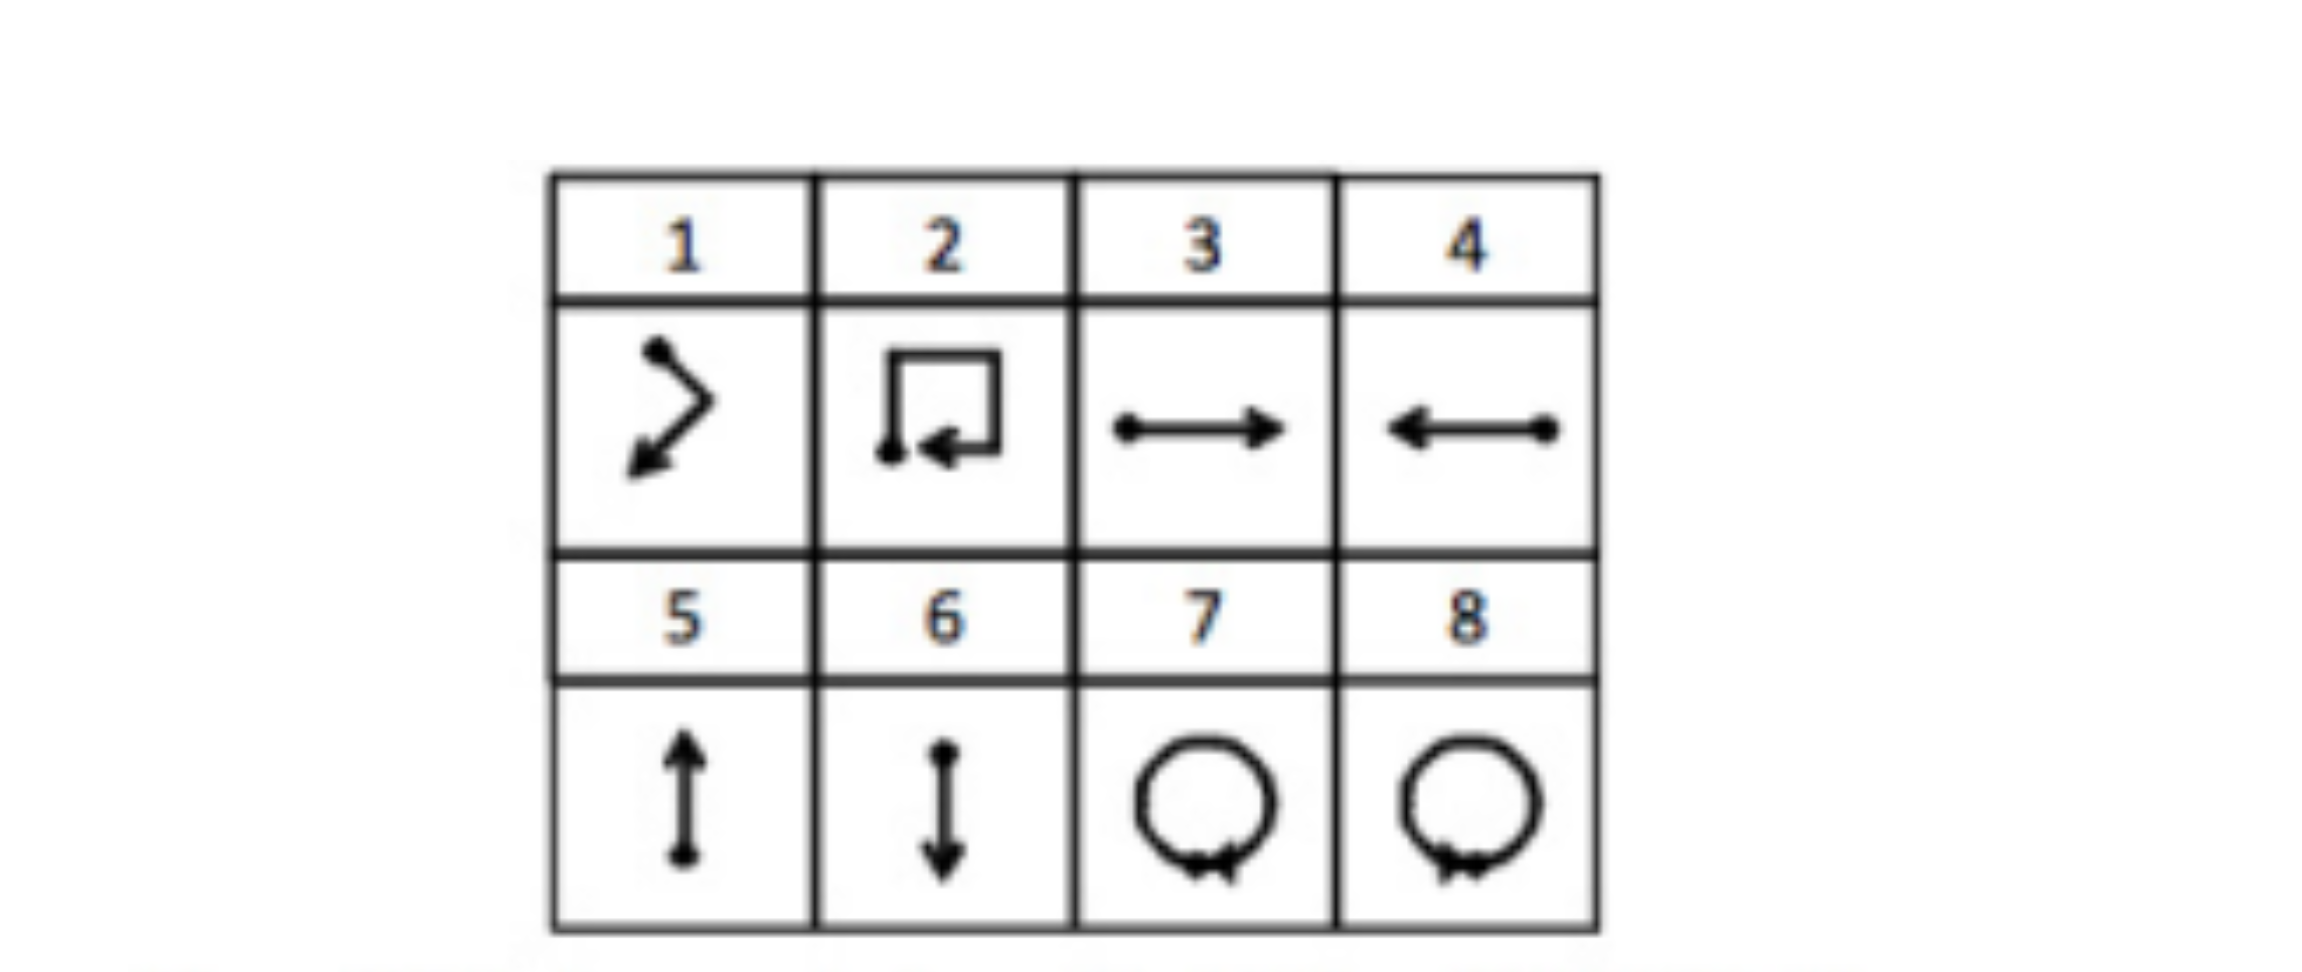

### Impact of regularization (Takes a long time to run)

In [15]:
reg_strengths = np.linspace(0, 30, 16)
test_accs = np.zeros(reg_strengths.shape[0])
train_accs = np.zeros(reg_strengths.shape[0])
weight_array = np.zeros((reg_strengths.shape[0], np.ndarray.flatten(model_reg.weights).shape[0]))
j = 0
for i in reg_strengths:
    print(j)
    model_w = LogisticRegression(learning_rate=0.2, n_iterations=5000, regularization=True, reg_strength=i, lr_decay=3e-6)
    train_loss_w, val_loss_w = model_w.fit(X_train, y_train, validation=True, X_val=X_val, y_val=y_val)
    weight_array[j, ] = np.ndarray.flatten(model_w.weights)
    # Test set
    logits, y_pred = model_w.predict(X_test)
    test_accs[j] = model_w.accuracy(y_pred, y_test)
    
    # Train set
    logits, y_pred_train = model_w.predict(X_train)
    train_accs[j] = model_w.accuracy(y_pred_train, y_train)
    j += 1
weight_array = np.abs(weight_array).T

0
Iteration:  0
Train loss:  25.094916138106672
Validation loss:  27.06722511964095
Iteration:  100
Train loss:  2.0465152017864514
Validation loss:  3.145893105077823
Iteration:  200
Train loss:  1.3503357282368877
Validation loss:  2.4914038691463114
Iteration:  300
Train loss:  1.077775029754967
Validation loss:  2.2206171146064433
Iteration:  400
Train loss:  0.9178451697983135
Validation loss:  2.088276573992682
Iteration:  500
Train loss:  0.8137753180691596
Validation loss:  1.972102194618834
Iteration:  600
Train loss:  0.7387855706089426
Validation loss:  1.871270577693205
Iteration:  700
Train loss:  0.6813879133401987
Validation loss:  1.7903878377318574
Iteration:  800
Train loss:  0.6364753577411393
Validation loss:  1.7231506771853595
Iteration:  900
Train loss:  0.5994771267064694
Validation loss:  1.6628250119045098
Iteration:  1000
Train loss:  0.5678872009875863
Validation loss:  1.6091063912915717
Iteration:  1100
Train loss:  0.5404455432421942
Validation loss:  1.5

Iteration:  4700
Train loss:  0.8946359017897638
Validation loss:  4.113463692530618
Iteration:  4800
Train loss:  0.8779039797219284
Validation loss:  4.032821132019497
Iteration:  4900
Train loss:  0.861630730187366
Validation loss:  3.954226009789182
2
Iteration:  0
Train loss:  29.480115043579097
Validation loss:  49.0136969508281
Iteration:  100
Train loss:  6.07095050460867
Validation loss:  23.476528407067743
Iteration:  200
Train loss:  5.138639097025942
Validation loss:  21.666333806920232
Iteration:  300
Train loss:  4.6544950609907945
Validation loss:  20.352980440767627
Iteration:  400
Train loss:  4.301296853604661
Validation loss:  19.2464719601329
Iteration:  500
Train loss:  4.018176742358292
Validation loss:  18.21868675413301
Iteration:  600
Train loss:  3.7753427599013807
Validation loss:  17.26551329080906
Iteration:  700
Train loss:  3.5611608830405483
Validation loss:  16.384738879416506
Iteration:  800
Train loss:  3.367935025451842
Validation loss:  15.559333514

Iteration:  4400
Train loss:  0.5376633262343992
Validation loss:  2.0334744004199106
Iteration:  4500
Train loss:  0.5201609027871177
Validation loss:  1.9450571096810487
Iteration:  4600
Train loss:  0.5039059702008687
Validation loss:  1.8628627385950112
Iteration:  4700
Train loss:  0.48880872489026556
Validation loss:  1.7864504110514667
Iteration:  4800
Train loss:  0.4747858894468792
Validation loss:  1.7154107607003428
Iteration:  4900
Train loss:  0.461760237673725
Validation loss:  1.6493636477763003
4
Iteration:  0
Train loss:  33.861126569741934
Validation loss:  70.93923796047679
Iteration:  100
Train loss:  9.712547128017194
Validation loss:  41.88787131695436
Iteration:  200
Train loss:  8.224361899697938
Validation loss:  37.313979053504625
Iteration:  300
Train loss:  7.258242795764341
Validation loss:  33.59677318235323
Iteration:  400
Train loss:  6.485168962340823
Validation loss:  30.370182604121023
Iteration:  500
Train loss:  5.833466851483753
Validation loss:  2

Iteration:  4100
Train loss:  0.3873552318419077
Validation loss:  1.1310948041814741
Iteration:  4200
Train loss:  0.3792346832960696
Validation loss:  1.0896912100017804
Iteration:  4300
Train loss:  0.37204262023666956
Validation loss:  1.0529856143482437
Iteration:  4400
Train loss:  0.3656724508108005
Validation loss:  1.0204428169707447
Iteration:  4500
Train loss:  0.36002989229299437
Validation loss:  0.9915888479688914
Iteration:  4600
Train loss:  0.3550315365975561
Validation loss:  0.9660039272964029
Iteration:  4700
Train loss:  0.3506035853732258
Validation loss:  0.9433162380085911
Iteration:  4800
Train loss:  0.34668073420120765
Validation loss:  0.923196418739246
Iteration:  4900
Train loss:  0.3432051879711507
Validation loss:  0.9053526920462306
6
Iteration:  0
Train loss:  38.237952214273946
Validation loss:  92.84385563461686
Iteration:  100
Train loss:  12.998296548052963
Validation loss:  58.515384506846345
Iteration:  200
Train loss:  10.704175497284453
Validat

Iteration:  3800
Train loss:  0.3573713773309095
Validation loss:  0.8896384028118249
Iteration:  3900
Train loss:  0.35378010168723234
Validation loss:  0.8712128910942122
Iteration:  4000
Train loss:  0.35074746875184765
Validation loss:  0.8556288684748562
Iteration:  4100
Train loss:  0.3481863959080012
Validation loss:  0.8424462614525933
Iteration:  4200
Train loss:  0.34602341089655214
Validation loss:  0.8312933799239075
Iteration:  4300
Train loss:  0.3441965174444897
Validation loss:  0.8218562595844287
Iteration:  4400
Train loss:  0.3426533971419869
Validation loss:  0.8138696706401978
Iteration:  4500
Train loss:  0.3413498942247119
Validation loss:  0.8071095311524478
Iteration:  4600
Train loss:  0.34024873848362136
Validation loss:  0.8013865047282552
Iteration:  4700
Train loss:  0.33931846868392823
Validation loss:  0.796540597033108
Iteration:  4800
Train loss:  0.33853252486730273
Validation loss:  0.7924365948206131
Iteration:  4900
Train loss:  0.3378684829338758


Iteration:  3500
Train loss:  0.35774888235932645
Validation loss:  0.8263560571656456
Iteration:  3600
Train loss:  0.35595518810204657
Validation loss:  0.8170881647307475
Iteration:  3700
Train loss:  0.3545111203158713
Validation loss:  0.8096063317545573
Iteration:  3800
Train loss:  0.35334843708877733
Validation loss:  0.8035645757428087
Iteration:  3900
Train loss:  0.3524122385244876
Validation loss:  0.7986841876346551
Iteration:  4000
Train loss:  0.3516583528713707
Validation loss:  0.7947406116328023
Iteration:  4100
Train loss:  0.3510512360505745
Validation loss:  0.7915528906921449
Iteration:  4200
Train loss:  0.3505622834221121
Validation loss:  0.7889751746155189
Iteration:  4300
Train loss:  0.35016847264220774
Validation loss:  0.7868898866323403
Iteration:  4400
Train loss:  0.3498512724981215
Validation loss:  0.7852022237339844
Iteration:  4500
Train loss:  0.3495957654565962
Validation loss:  0.7838357297859615
Iteration:  4600
Train loss:  0.34938994196512074


Iteration:  3100
Train loss:  0.3665685766365228
Validation loss:  0.8197326523396006
Iteration:  3200
Train loss:  0.36515963257933926
Validation loss:  0.8124318504076735
Iteration:  3300
Train loss:  0.3640783809796938
Validation loss:  0.8068075033136485
Iteration:  3400
Train loss:  0.3632485274323387
Validation loss:  0.8024725114262391
Iteration:  3500
Train loss:  0.3626115629967402
Validation loss:  0.7991295067510454
Iteration:  3600
Train loss:  0.36212261177154825
Validation loss:  0.7965499902930788
Iteration:  3700
Train loss:  0.3617472497671629
Validation loss:  0.7945583324856882
Iteration:  3800
Train loss:  0.361459067352674
Validation loss:  0.7930195003068551
Iteration:  3900
Train loss:  0.3612378010978061
Validation loss:  0.7918296409402676
Iteration:  4000
Train loss:  0.36106790173945924
Validation loss:  0.7909088555134647
Iteration:  4100
Train loss:  0.3609374362715627
Validation loss:  0.7901956523142514
Iteration:  4200
Train loss:  0.36083724606718437
Va

Iteration:  2700
Train loss:  0.37656425999689885
Validation loss:  0.8278148115438988
Iteration:  2800
Train loss:  0.37504469805371543
Validation loss:  0.8199524969167865
Iteration:  2900
Train loss:  0.3739332322736329
Validation loss:  0.8141755572536846
Iteration:  3000
Train loss:  0.37312016594944714
Validation loss:  0.8099279121030101
Iteration:  3100
Train loss:  0.3725253202595292
Validation loss:  0.8068023157360946
Iteration:  3200
Train loss:  0.37209008128944004
Validation loss:  0.8045004094323597
Iteration:  3300
Train loss:  0.37177159312200575
Validation loss:  0.8028035212972613
Iteration:  3400
Train loss:  0.37153851680112016
Validation loss:  0.8015513156394204
Iteration:  3500
Train loss:  0.37136793219472725
Validation loss:  0.8006261771508734
Iteration:  3600
Train loss:  0.3712430742767632
Validation loss:  0.7999417861317506
Iteration:  3700
Train loss:  0.37115167876957667
Validation loss:  0.7994347574562252
Iteration:  3800
Train loss:  0.37108477289743

Iteration:  2300
Train loss:  0.38773170183587247
Validation loss:  0.847945114110946
Iteration:  2400
Train loss:  0.38543766217811787
Validation loss:  0.8361431685896709
Iteration:  2500
Train loss:  0.38383862152182713
Validation loss:  0.827879465947037
Iteration:  2600
Train loss:  0.38272384801590864
Validation loss:  0.8220884010268196
Iteration:  2700
Train loss:  0.3819465693285105
Validation loss:  0.8180263261159872
Iteration:  2800
Train loss:  0.381404537330598
Validation loss:  0.815174035642715
Iteration:  2900
Train loss:  0.38102650693469975
Validation loss:  0.8131688489572093
Iteration:  3000
Train loss:  0.380762826322961
Validation loss:  0.8117572894875584
Iteration:  3100
Train loss:  0.38057888647982285
Validation loss:  0.8107621019716353
Iteration:  3200
Train loss:  0.38045055997070343
Validation loss:  0.8100592548353548
Iteration:  3300
Train loss:  0.38036102410502026
Validation loss:  0.8095618988204445
Iteration:  3400
Train loss:  0.38029854782013117
V

Text(0.5, 1.0, 'Absolute weight size distribution and train/test accuracy for different regularization strengths')

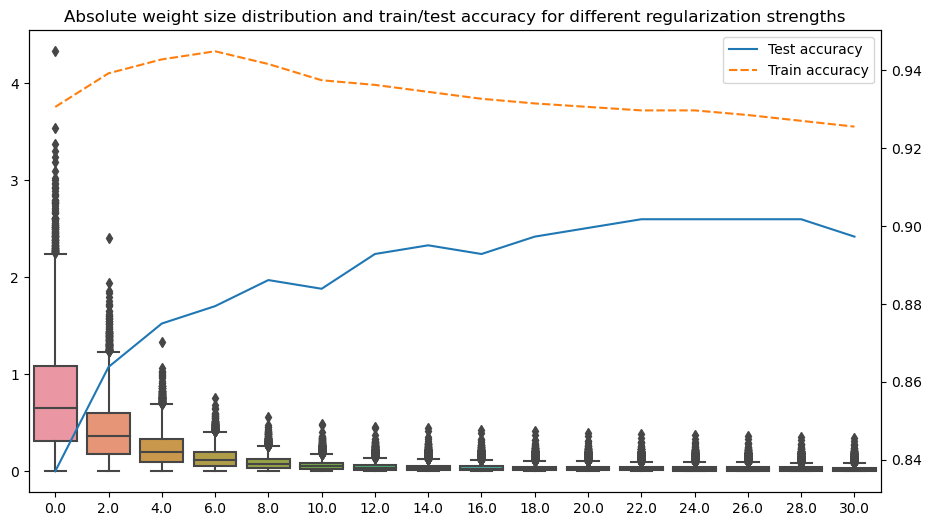

In [16]:
weight_df = pd.DataFrame(weight_array)
fig, ax = plt.subplots()
fig.set_size_inches(11, 6)
ax2 = ax.twinx()
sns.boxplot(data=weight_df, ax=ax)
sns.lineplot(data=pd.DataFrame({"Test accuracy": test_accs, "Train accuracy": train_accs}), ax=ax2).set_xticklabels(reg_strengths)
plt.title("Absolute weight size distribution and train/test accuracy for different regularization strengths")

This chart helps to visualize how higher regularization strengths overall lead to smaller absolute weights and thus prevent the model to overfit (doesn't generalize). As the regularization strength increases, the train and test accuracy converge towards each other.